In [1]:
from IPython.display import display, HTML
import os
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
%run nb_core/root_dirs.ipynb
setup_syspath_disentangle(False)
%run nb_core/disentangle_imports.ipynb

DATA_ROOT:	 /group/jug/ashesh/data/
CODE_ROOT:	 /home/ashesh.ashesh/


In [4]:
from disentangle.analysis.ssl_normalization_utils import get_input_normalized, get_input_unnormalized
from disentangle.data_loader.patch_index_manager import TilingMode
from disentangle.core.sampler_type import SamplerType
from disentangle.core.loss_type import LossType
from disentangle.data_loader.ht_iba1_ki67_rawdata_loader import SubDsetType
from disentangle.data_loader.sox2golgi_v2_rawdata_loader import Sox2GolgiV2ChannelList
from disentangle.data_loader.multifile_raw_dloader import SubDsetType
import ml_collections
from disentangle.core.tiff_reader import load_tiff
from disentangle.analysis.paper_plots import show_for_one, get_plotoutput_dir
from disentangle.analysis.ssl_normalization_utils import normalize_input
from finetunesplit.asymmetric_transforms import TransformAllChannels, VFlip, Rotate, HFlip, DeepinvTransform
import deepinv




In [5]:
ckpt_dir = '/group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L0/14'
# ckpt_dir = '/group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L0/12'

# ckpt_dir = '/group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L2/3'
# ckpt_dir = "/group/jug/ashesh/training/disentangle/2503/D17-M3-S0-L0/5"
# ckpt_dir = '/group/jug/ashesh/training/disentangle/2404/D21-M3-S0-L8/1'
assert os.path.exists(ckpt_dir)
image_size_for_grid_centers = None
mmse_count = 2
custom_image_size = None
save_to_file = False

use_selected_fpaths = None#['Test1_Slice2_a/4.nd2']
sample_mixing_ratio = True
use_first_k_images = 1
tiling_mode = TilingMode.ShiftBoundary
real_input = True

save_comparative_plots =False
enable_calibration = False
batch_size = 16
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Test 
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'


# augmentation related
aug_theta_max = 0
aug_theta_z_max = 0
aug_shift_max=0.0
enable_mixing_aug = True

# finetuningng related 
max_step_count_step1 = 20000//16
max_step_count_step2 =200000//16
skip_pixels = 4
lr_step1 = 1e-3
lr_step2 = 1e-5
lookback = 10
k_augmentations=4
optimaization_mode = 'twostep'
k_moment_value = 2
outputdir = '/group/jug/ashesh/finetuning_results/'


In [6]:
import numpy as np

data_t_list = None
if use_first_k_images is not None and use_first_k_images > 0:
    data_t_list = np.arange(use_first_k_images).tolist()

assert optimaization_mode in ['onestep', 'twostep', 'norm_and_network'], f"Invalid optimization mode: {optimaization_mode}"

In [7]:
def get_dtype(ckpt_fpath):
    if os.path.isdir(ckpt_fpath):
        ckpt_fpath = ckpt_fpath[:-1] if ckpt_fpath[-1] == '/' else ckpt_fpath
    elif os.path.isfile(ckpt_fpath):
        ckpt_fpath = os.path.dirname(ckpt_fpath)
    assert ckpt_fpath[-1] != '/'
    return int(ckpt_fpath.split('/')[-2].split('-')[0][1:])

In [8]:
dtype = get_dtype(ckpt_dir)
dtype

21

In [9]:
%run nb_core/config_loader.ipynb

data:
  background_quantile: 0.0
  channel_idx_list:
  - GT_Cy5
  - GT_TRITC
  clip_background_noise_to_zero: false
  clip_percentile: 1.0
  data_type: 21
  deterministic_grid: false
  end_alpha:
  - 0.8
  - 0.8
  grid_size: 16
  image_size: 32
  input_is_sum: false
  multiscale_lowres_count: null
  normalized_input: true
  num_channels: 2
  padding_mode: reflect
  padding_value: null
  randomized_channels: false
  sampler_type: 0
  skip_normalization_using_mean: false
  start_alpha:
  - 0.2
  - 0.2
  subdset_type: 2
  target_idx_list:
  - 0
  - 1
  target_separate_normalization: true
  train_aug_rotate: false
  uncorrelated_channel_probab: 1.0
  uncorrelated_channels: true
  use_one_mu_std: true
  val_grid_size: 16
datadir: /group/jug/ashesh/data/TavernaSox2Golgi/acquisition2/
exptname: 2504/D21-M3-S0-L0/12
git:
  branch: lyonResearch
  changedFiles:
  - disentangle/analysis/ssl_plots.py
  - disentangle/notebooks/SelfSupervisionExperiment.ipynb
  latest_commit: 2b9742f6c3dee7181c8e4eb

In [10]:
tokens = ckpt_dir.split('/')
idx = tokens.index('disentangle')
if config.model.model_type == 25 and tokens[idx+1] == '2312':
    config.model.model_type = ModelType.LadderVAERestrictedReconstruction

In [11]:
# from disentangle.core.lowres_merge_type import LowresMergeType


with config.unlocked():
    if 'depth3D' in config.data and config.data.depth3D > 1:
        config.data.mode_3D = True
        config.model.mode_3D = True
        
    config.model.skip_nboundary_pixels_from_loss = None
    if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
        config.model.n_levels = 4
    if config.data.sampler_type == SamplerType.NeighborSampler:
        config.data.sampler_type = SamplerType.DefaultSampler
        config.loss.loss_type = LossType.Elbo
        config.data.grid_size = config.data.image_size
    if 'ch1_fpath_list' in config.data:
        config.data.ch1_fpath_list = config.data.ch1_fpath_list[:1]
        config.data.mix_fpath_list = config.data.mix_fpath_list[:1]
    if config.data.data_type == DataType.Pavia2VanillaSplitting:
        if 'channel_2_downscale_factor' not in config.data:
            config.data.channel_2_downscale_factor = 1
    if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
        config.model.init_channel_count = 64
    
    if 'skip_receptive_field_loss_tokens' not in config.loss:
        config.loss.skip_receptive_field_loss_tokens = []
    
    if dtype == DataType.HTIba1Ki67:
        config.data.subdset_type = SubDsetType.OnlyIba1P30
        config.data.empty_patch_replacement_enabled = False
    
    if 'lowres_merge_type' not in config.model.encoder:
        config.model.encoder.lowres_merge_type = 0
    if 'validtarget_random_fraction' in config.data:
        config.data.validtarget_random_fraction = None
    
    if config.data.data_type == DataType.TwoDset:
        config.model.model_type = ModelType.LadderVae
        for key in config.data.dset1:
            config.data[key] = config.data.dset1[key]
    
    if 'dump_kth_frame_prediction' in config.training:
        config.training.dump_kth_frame_prediction = None

    if 'input_is_sum' not in config.data:
        config.data.input_is_sum = False

## Replace the dataset

In [12]:

with config.unlocked():
    if config.data.data_type in [DataType.TavernaSox2Golgi]:
        config.data.data_type = DataType.TavernaSox2GolgiV2
        config.data.subdset_type = SubDsetType.MultiChannel
        if real_input:
            print('Real Input being used')
            # all channels: ['555-647', 'GT_Cy5', 'GT_TRITC']
            config.data.channel_idx_list = [
                    Sox2GolgiV2ChannelList.GT_TRITC,Sox2GolgiV2ChannelList.GT_Cy5, Sox2GolgiV2ChannelList.GT_555_647
                ]
            config.data.input_idx = 2
        else:
            print('Real Input not being used')
            config.data.channel_idx_list = [
                    Sox2GolgiV2ChannelList.GT_TRITC,Sox2GolgiV2ChannelList.GT_Cy5
                ]
            config.data.input_idx = None

        config.data.num_channels = len(config.data.channel_idx_list)
    if use_selected_fpaths is not None:
        config.data.use_selected_fpaths = use_selected_fpaths
    config.data.target_idx_list = [0, 1]
    config.model.num_targets = len(config.data.target_idx_list)

In [13]:
dtype = config.data.data_type

if dtype in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
    data_dir = f'{DATA_ROOT}/sinosoid_without_test/sinosoid/'
elif dtype == DataType.OptiMEM100_014:
    data_dir = f'{DATA_ROOT}/microscopy/'
elif dtype == DataType.Prevedel_EMBL:
    data_dir = f'{DATA_ROOT}/Prevedel_EMBL/PKG_3P_dualcolor_stacks/NoAverage_NoRegistration/'
elif dtype == DataType.AllenCellMito:
    data_dir = f'{DATA_ROOT}/allencell/2017_03_08_Struct_First_Pass_Seg/AICS-11/'
elif dtype == DataType.SeparateTiffData:
    data_dir = f'{DATA_ROOT}/ventura_gigascience'
elif dtype == DataType.SemiSupBloodVesselsEMBL:
    data_dir = f'{DATA_ROOT}/EMBL_halfsupervised/Demixing_3P'
elif dtype == DataType.Pavia2VanillaSplitting:
    data_dir = f'{DATA_ROOT}/pavia2'
# elif dtype == DataType.ExpansionMicroscopyMitoTub:
    # data_dir = f'{DATA_ROOT}/expansion_microscopy_Nick/'
elif dtype == DataType.ShroffMitoEr:
    data_dir = f'{DATA_ROOT}/shrofflab/'
elif dtype == DataType.HTIba1Ki67:
    data_dir = f'{DATA_ROOT}/Stefania/20230327_Ki67_and_Iba1_trainingdata/'
elif dtype == DataType.BioSR_MRC:
    data_dir = f'{DATA_ROOT}/BioSR/'
elif dtype == DataType.ExpMicroscopyV2:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_v2/datafiles/'
elif dtype == DataType.TavernaSox2Golgi:
    data_dir = f'{DATA_ROOT}/TavernaSox2Golgi/'
elif dtype == DataType.TavernaSox2GolgiV2:
    data_dir = f'{DATA_ROOT}/TavernaSox2Golgi/acquisition2/'
elif dtype == DataType.Pavia3SeqData:
    data_dir = f'{DATA_ROOT}/pavia3_sequential/'
elif dtype == DataType.NicolaData:
    data_dir = f'{DATA_ROOT}/nikola_data/20240531/'
elif dtype == DataType.Dao3ChannelWithInput:
    data_dir = f'{DATA_ROOT}/Dao4Channel/'
elif dtype == DataType.Dao3Channel:
    data_dir = f'{DATA_ROOT}/Dao3Channel/'
elif dtype == DataType.SilvioLabCSHLData:
    data_dir = f'{DATA_ROOT}/svilen_cshl2024/'
elif dtype == DataType.ExpMicroscopyV3:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_v4/405_NHS_488BODIPY/'
elif dtype == DataType.Elisa3DData:
    data_dir = f'{DATA_ROOT}/Elisa3D/'

In [14]:
# config.model.noise_model_ch1_fpath = config.model.noise_model_ch1_fpath.replace('/home/ashesh.ashesh/training/', '/group/jug/ashesh/training_pre_eccv/')
# config.model.noise_model_ch2_fpath = config.model.noise_model_ch2_fpath.replace('/home/ashesh.ashesh/training/', '/group/jug/ashesh/training_pre_eccv/')

In [15]:
%run nb_core/disentangle_setup.ipynb


Loading data from /group/jug/ashesh/data//TavernaSox2Golgi/acquisition2/ with channel names ['GT_Cy5', 'GT_TRITC'], datasplit_type Train

Loaded from MultiChannel /group/jug/ashesh/data//TavernaSox2Golgi/acquisition2/ 292/365 frames




































































































































































































































































































[SingleFileDset] Train:1 Sz:3210000 DimSz:(1,100,100,1) TrimB:2 Rot:False RandCrop:True Channel:2 Uncorr:True Alpha:[[0.2, 0.2],[0.8, 0.8]]
MultiFileDset avg height: 1608, avg width: 1608, count: 292
Loading data from /group/jug/ashesh/data//TavernaSox2Golgi/acquisition2/ with channel names ['GT_Cy5', 'GT_TRITC'], datasplit_type Test

Loaded from MultiChannel /group/jug/ashesh/data//TavernaSox2Golgi/acquisition2/ 36/365 frames




































[Single

In [16]:
# from disentangle.core.tiff_reader import save_tiff
# save_tiff('/group/jug/ashesh/data/golgi_one_img.tiff', val_dset.dsets[0]._data[0,...,0])

In [17]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

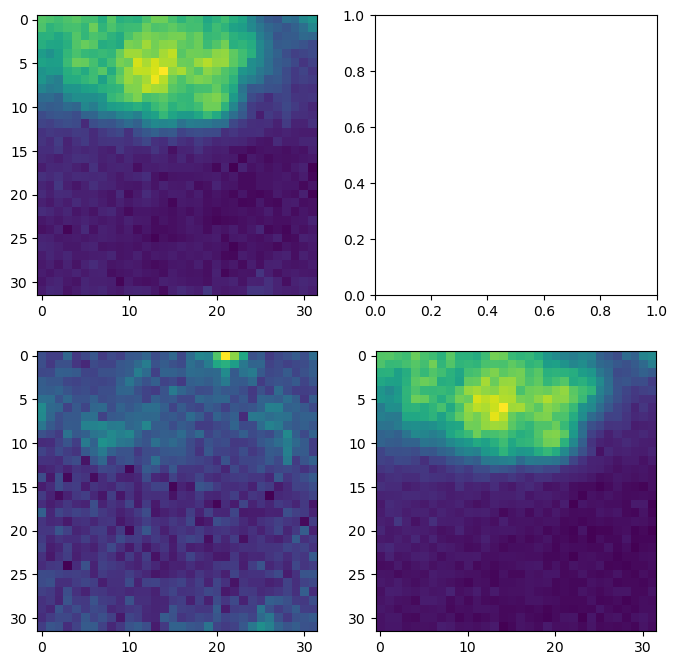

In [18]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
ncols = len(tar_tmp)
nrows = 2
_,ax = plt.subplots(figsize=(4*ncols,4*nrows),ncols=ncols,nrows=nrows)
for i in range(min(ncols,len(inp_tmp))):
    ax[0,i].imshow(inp_tmp[i])

for channel_id in range(ncols):
    ax[1,channel_id].imshow(tar_tmp[channel_id])

In [19]:
if data_t_list is not None:
    val_dset.reduce_data(t_list=data_t_list)

[MultiFileDset] Data reduced. New data count: 1


In [20]:
# # high val dset 
# import ml_collections
# new_config = ml_collections.ConfigDict(config)
# highsnr_val_dset = None
# if 'poisson_noise_factor' in new_config.data and new_config.data.poisson_noise_factor > 0:
#     new_config.data.poisson_noise_factor = -1
#     _, highsnr_val_dset = create_dataset(new_config, data_dir, eval_datasplit_type=eval_datasplit_type,
#                                         kwargs_dict=dloader_kwargs)



In [21]:
assert save_comparative_plots is False

## Self-supervision
Here, we now do some self-supervised finetuning. 

In [22]:
print('Loading checkpoint from', ckpt_fpath)
checkpoint = torch.load(ckpt_fpath)
_ = model.load_state_dict(checkpoint['state_dict'], strict=False)


Loading checkpoint from /group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L0/12/BaselineVAECL_best.ckpt


In [23]:
from disentangle.analysis.stitch_prediction import stitch_predictions
from disentangle.analysis.mmse_prediction import get_dset_predictions
from deepinv.transform.projective import Homography
from finetunesplit.asymmetric_transforms import get_inverse_transforms
from disentangle.core.psnr import RangeInvariantPsnr

pred_tiled, rec_loss, logvar_tiled, patch_psnr_tuple, pred_std_tiled = get_dset_predictions(model, val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=mmse_count,
                                                model_type = config.model.model_type,
                                              )
tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp))

  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:40<00:00, 15.30it/s]


Patch wise PSNR, as computed during training [40.3  29.37] 34.835


In [24]:
mean_channels = np.mean(pred_tiled, axis=(2,3)).mean(axis=0)
std_channels = np.std(pred_tiled, axis=(2,3)).mean(axis=0)
mean_channels, std_channels

(array([0.04672621, 0.35864586], dtype=float32),
 array([0.34799677, 0.46304214], dtype=float32))

In [25]:
from disentangle.loss.ssl_finetuning import get_stats_loss_func
stats_loss_func = get_stats_loss_func(pred_tiled, k_moment_value)
stats_loss_func(torch.Tensor(pred_tiled[:15]))
# def k_moment(data, k):
#     # data: N x C x H x W
#     dif = data - np.mean(data, axis=(2,3))[...,None, None]
#     moment = np.mean(dif**k, axis=(2,3))
#     neg_vals = moment < 0
#     moment = np.power(np.abs(moment), 1/k)
#     moment[neg_vals] = -moment[neg_vals]
#     return moment.mean(axis=0)

# k_moment(pred_tiled, 2)
# import torch
# def get_stats_loss_func():
#     mean_channels = torch.Tensor(np.mean(pred_tiled, axis=(2,3)).mean(axis=0))
#     std_channels = torch.Tensor(np.std(pred_tiled, axis=(2,3)).mean(axis=0))
#     def stats_loss_func(two_channel_prediction):
#         mean_pred = torch.mean(two_channel_prediction, dim=(2,3)).mean(dim=0)
#         std_pred = torch.std(two_channel_prediction, dim=(2,3)).mean(dim=0)
#         device = std_pred.device
#         print('est_moment', mean_pred)
#         print('actual_moment', mean_channels)
#         mean_err =  mean_channels.to(device) - mean_pred
#         mean_err = torch.clip(mean_err, min=0)
#         print('est_moment', std_pred)
#         print('actual_moment', std_channels)

#         std_err = std_channels.to(device) - std_pred
#         std_err = torch.clip(std_err, min=0)
#         mean_loss = torch.mean(mean_err)
#         std_loss = torch.mean(std_err)
#         return  mean_loss + std_loss
#     return stats_loss_func
# stats_loss_func = get_stats_loss_func()


Creating stats loss function with k=2


tensor(1.4254)

In [26]:
idx_list = np.where(logvar_tiled.squeeze() < -6)[0]
if len(idx_list) > 0:
    plt.imshow(val_dset[idx_list[0]][1][1])

In [27]:
len(val_dset)

10000

In [28]:
print(np.quantile(rec_loss, [0,0.01,0.5, 0.9,0.99,0.999,1]).round(2))

[-1.34 -1.27  0.12  0.74  1.44  1.9   2.06]


In [29]:
if pred_tiled.shape[-1] != val_dset.get_img_sz():
    pad = (val_dset.get_img_sz() - pred_tiled.shape[-1] )//2
    pred_tiled = np.pad(pred_tiled, ((0,0),(0,0),(pad,pad),(pad,pad)))

pred = stitch_predictions(pred_tiled,val_dset, )
if len(np.unique(logvar_tiled)) == 1:
    logvar = None
else:
    logvar = stitch_predictions(logvar_tiled,val_dset, )
pred_std = stitch_predictions(pred_std_tiled,val_dset, )

pred_original = pred.copy()

In [30]:
pred[0].shape

(1, 1608, 1608, 2)

In [31]:
pred_tiled.shape

(10000, 2, 32, 32)

In [32]:
is_list_prediction = isinstance(pred, list)
tar_unnorm = (val_dset._data if not is_list_prediction else [val_dset.dsets[i]._data for i in range(len(val_dset.dsets))])

In [33]:
tar_unnorm[0].shape

(1, 1608, 1608, 2)

In [34]:
nTar = pred[0].shape[-1]
if "target_idx_list" in config.data and config.data.target_idx_list is not None:
    nTar =len(config.data.target_idx_list)
    # pred = pred[..., :len(config.data.target_idx_list)] if not is_list_prediction else [pred[i][..., :len(config.data.target_idx_list)] for i in range(len(pred))]
    # pred_std = pred_std[...,:len(config.data.target_idx_list)] if not is_list_prediction else [pred_std[i][..., :len(config.data.target_idx_list)] for i in range(len(pred_std))]

if 'input_idx' in config.data and config.data.input_idx is not None:
    inp_unnorm = [x[...,config.data.input_idx] for x in tar_unnorm]
    tar_unnorm = [x[...,:nTar] for x in tar_unnorm]
else:
    inp_unnorm = [x.mean(axis=-1) for x in tar_unnorm]

actual_input = normalize_input(inp_unnorm, val_dset)



### Optimal Estimation of t

In [35]:
import numpy as np
from tqdm import tqdm
mean_psnr_arr = []
std_psnr_arr = []
t_values = np.arange(0.0,1.0, 0.05) 
for t in tqdm(t_values):
    inp_tiled = [(t *pred[i][...,0] + (1-t)*pred[i][...,1]) for i in range(len(pred))]
    psnr_values = [RangeInvariantPsnr(inp_unnorm[i]*1.0, inp_tiled[i]).item() for i in range(len(inp_unnorm))]
    mean_psnr_arr.append(np.mean(psnr_values))
    std_psnr_arr.append(np.std(psnr_values))

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 29.90it/s]


In [36]:
best_idx = np.argmax(mean_psnr_arr)
best_t_estimate = t_values[best_idx]
print(f'Best t value: {best_t_estimate}')

Best t value: 0.4


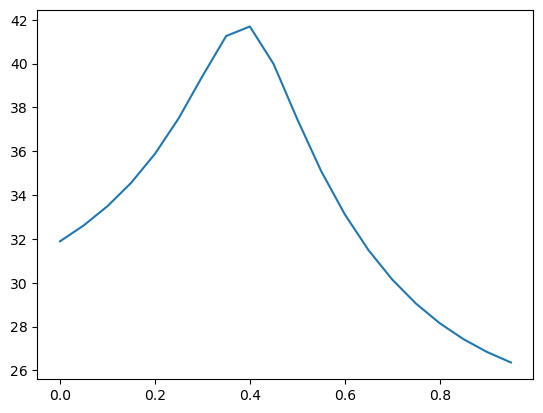

In [37]:
plt.plot(t_values, mean_psnr_arr)

In [38]:
def print_ignored_pixels():
    ignored_pixels = 1
    while(pred[0,-ignored_pixels:,-ignored_pixels:,].std() ==0):
        ignored_pixels+=1
    ignored_pixels-=1
    print(f'In {pred.shape}, last {ignored_pixels} many rows and columns are all zero.')
    return ignored_pixels

In [39]:
sep_mean, sep_std = model.data_mean["target"], model.data_std["target"]
sep_mean = sep_mean.squeeze().reshape(1, 1, 1, -1)
sep_std = sep_std.squeeze().reshape(1, 1, 1, -1)

In [40]:
pred[0].shape, sep_mean.shape, sep_std.shape

((1, 1608, 1608, 2), torch.Size([1, 1, 1, 2]), torch.Size([1, 1, 1, 2]))

In [41]:
def get_unnorm_pred(pred_arr):
    if is_list_prediction:
        pred_unnorm = [pred_arr[i] * sep_std.cpu().numpy() + sep_mean.cpu().numpy() for i in range(len(pred_arr))]
    else:
        pred_unnorm = pred_arr * sep_std.cpu().numpy() + sep_mean.cpu().numpy()
    return pred_unnorm

def normalize_channels(channel_arr):
    if is_list_prediction:
        pred_unnorm = [(channel_arr[i] - sep_mean.cpu().numpy())/sep_std.cpu().numpy() for i in range(len(channel_arr))]
    else:
        pred_unnorm = (channel_arr - sep_mean.cpu().numpy())/ sep_std.cpu().numpy()
    return pred_unnorm

pred_unnorm = get_unnorm_pred(pred)

In [42]:
from disentangle.scripts.evaluate import compute_high_snr_stats
stats_dict = compute_high_snr_stats(tar_unnorm, pred_unnorm)

100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


PSNR on Highres 41.31+-0.0	30.3+-0.0
MicroSSIM on Highres 0.948+-0.000	0.887+-0.000
MicroS3IM on Highres 0.979+-0.000	0.928+-0.000
SSIM on Highres 0.978+-0.000	0.914+-0.000
MSSSIM on Highres 0.985+-0.000	0.924+-0.000


In [43]:
estimated_input = get_input_normalized(pred_original,best_t_estimate, channel_pos='last')
print('MSE-input', ' '.join([f'{np.mean((gt_tmp - pred_tmp)**2):.2f}' for gt_tmp,pred_tmp in zip(actual_input, estimated_input)]))


MSE-input 0.08


In [44]:
mean_inp, std_inp = val_dset.dsets[0].get_mean_std_for_input()
mean_inp = mean_inp.reshape(-1,)[0]
std_inp = std_inp.reshape(-1,)[0]
(mean_inp, std_inp)

(290.62273728334367, 152.04460199216427)

0 242 40


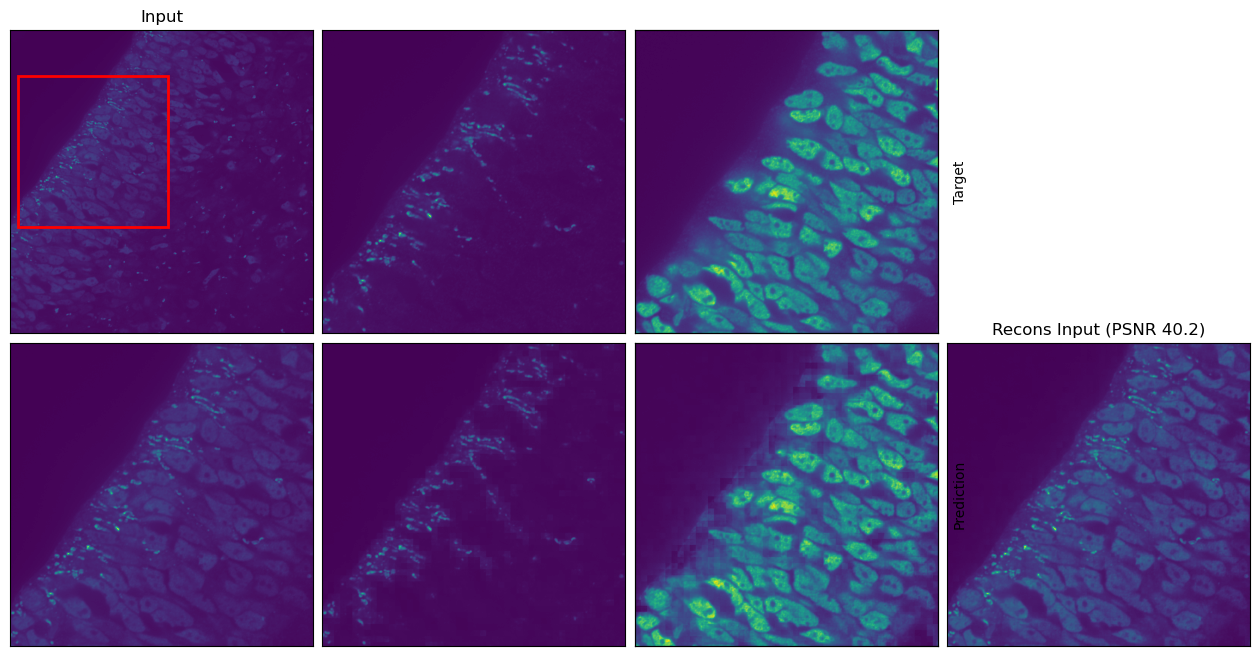

In [49]:
from disentangle.analysis.ssl_plots import plot_one_sample
img_idx, hs, ws = plot_one_sample(normalize_channels(tar_unnorm), pred, inp_unnorm, config, best_t_estimate)

## SSL finetuning. 

In [50]:
from torch.utils.data import DataLoader
from finetunesplit.loss import SSL_loss
from disentangle.loss.ssl_finetuning import finetune_two_forward_passes
from finetunesplit.asymmetric_transforms import TransformAllChannels, VFlip, Rotate, HFlip, DeepinvTransform
from deepinv.transform.projective import Homography

def reload():
    print('Loading checkpoint from', ckpt_fpath)
    checkpoint = torch.load(ckpt_fpath)
    _ = model.load_state_dict(checkpoint['state_dict'], strict=False)



In [52]:
transform_types = {0:[VFlip(), Rotate(),HFlip()], 1:[ VFlip(), HFlip(), Rotate()]}
if aug_shift_max > 0 or aug_theta_z_max or aug_theta_max > 0:
    trans_homo = Homography(n_trans = 1, zoom_factor_min=1.0, theta_max=aug_theta_max, 
                            theta_z_max=aug_theta_z_max, 
                            skew_max=0, 
                            shift_max=aug_shift_max,
                            x_stretch_factor_min = 1,
                            y_stretch_factor_min = 1, device = model.device)
    transform_types[0].append(DeepinvTransform(trans_homo))
    transform_types[1].append(DeepinvTransform(trans_homo))


transform_all = TransformAllChannels(transform_types)

# define a learnable scalar and an offset 
factor1 = torch.nn.Parameter(torch.tensor(1.0).cuda())
offset1 = torch.nn.Parameter(torch.tensor(0.0).cuda())

factor2 = torch.nn.Parameter(torch.tensor(1.0).cuda())
offset2 = torch.nn.Parameter(torch.tensor(0.0).cuda())
mixing_ratio = torch.nn.Parameter(torch.tensor(best_t_estimate).cuda())

if optimaization_mode == 'twostep':
    optimization_params = [factor1, offset1]
    finetuning_output_dict = finetune_two_forward_passes(model, val_dset, transform_all, 
                                                        max_step_count=max_step_count_step1, 
                                                        batch_size=batch_size, 
                                                        skip_pixels=skip_pixels,
                                    scalar_params_dict={'factor1':factor1, 'offset1':offset1, 'factor2':factor2, 'offset2':offset2, 'mixing_ratio':mixing_ratio},
                                    optimization_params_dict={'lr':lr_step1, 'parameters': optimization_params},
                                    lookback=lookback,
                                    k_augmentations=k_augmentations,
                                    stats_enforcing_loss_fn=lambda x : stats_loss_func(x),
                                    sample_mixing_ratio=enable_mixing_aug,
                                    )
    best_factors = finetuning_output_dict['best_factors']
    best_offsets = finetuning_output_dict['best_offsets']
elif optimaization_mode in ['onestep', 'norm_and_network']:
    print('Skipping the first optimization step')
    best_factors = [factor1.item(), factor2.item()]
    best_offsets = [offset1.item(), offset2.item()]

print(best_factors, best_offsets)

Finetuning with 4 augmentations, batch size 16, max step count 1000, sample mixing ratio True


11it [00:05,  1.85it/s]

Loss Inp Rolling(10): 0.09


13it [00:06,  1.86it/s]

Loss Inp Rolling(10): 0.09


14it [00:07,  1.85it/s]

Loss Inp Rolling(10): 0.08


62it [00:32,  1.89it/s]

Loading best model with loss 0.08
[1.012805700302124, 1.0] [-0.011982330121099949, 0.0]


In [53]:
from datetime import datetime
subdir = '_'.join(ckpt_dir.split('/')[-3:])
subsubdir = f'{optimaization_mode}_B-{batch_size}_lr-{lr_step1}-{lr_step2}_kaug-{k_augmentations}_maxstep-{max_step_count_step1}-{max_step_count_step2}_ang-{aug_theta_max}_angz-{aug_theta_z_max}_shift-{aug_shift_max}'
timesubdir = datetime.now().strftime("%Y%m%d")
direc = os.path.join(subdir,subsubdir,timesubdir)
print(direc)
if optimaization_mode == 'twostep':
    fpath = os.path.join(outputdir, direc, 'after_step1.ckpt')
    os.makedirs(os.path.dirname(fpath), exist_ok=True)
    if save_to_file:
        # save the model weights.
        torch.save(model.state_dict(), fpath)
        print(f'Saved the model weights to {fpath}')
        # save the factors and offsets
        fpath = os.path.join(outputdir, direc, 'factors_offsets.txt')
        with open(fpath, 'w') as f:
            f.write(f'Factor1{best_factors[0]} Offset1{best_offsets[0]} Factor2{best_factors[1]} Offset2{best_offsets[1]}')

    

2504_D21-M3-S0-L0_12/twostep_B-16_lr-0.001-1e-05_kaug-4_maxstep-1000-1000_ang-0_angz-0_shift-0.0/20250417


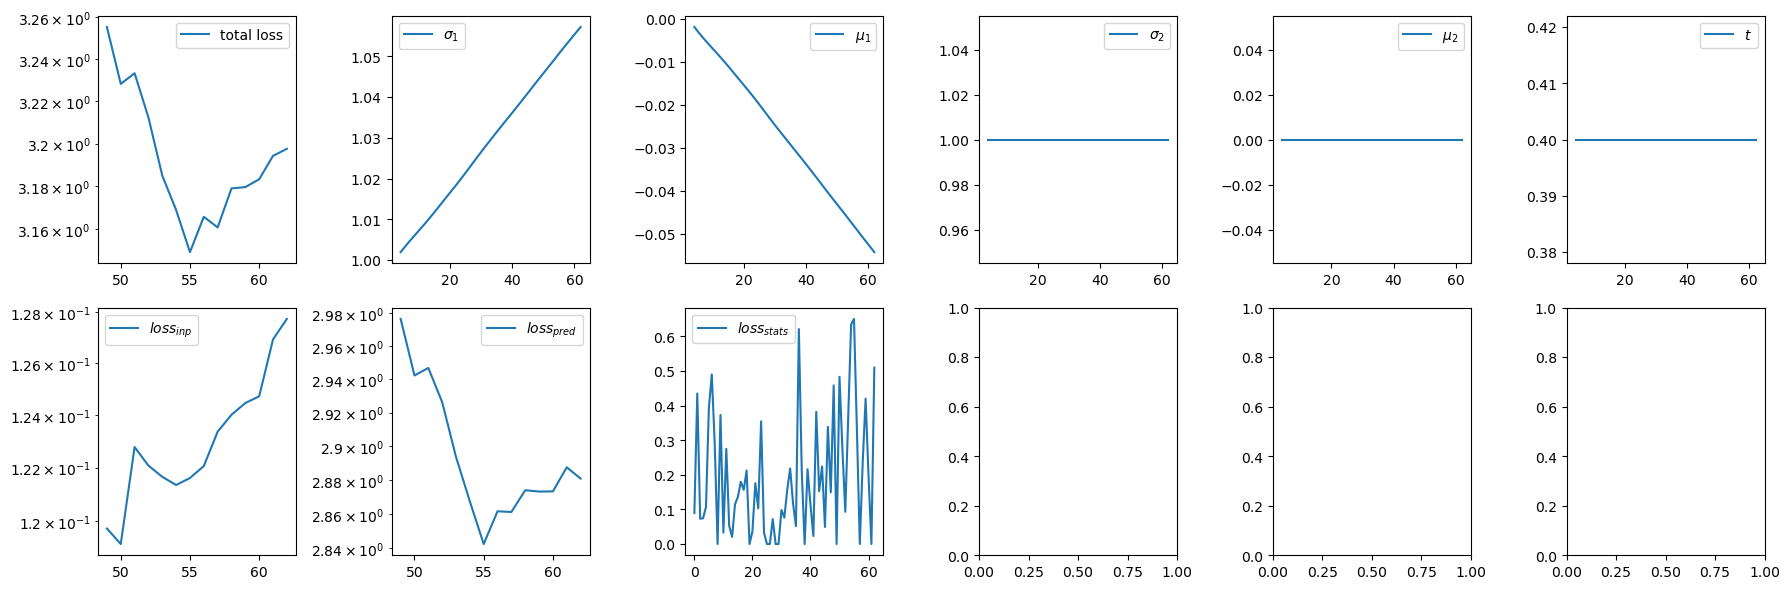

In [54]:
from disentangle.analysis.ssl_plots import plot_finetuning_loss
if optimaization_mode == 'twostep':
    plot_finetuning_loss(finetuning_output_dict)


In [55]:
class ScaledDataset:
    def __init__(self, dset, scalar, offset):
        self.dset = dset
        self.scalar = scalar
        self.offset = offset
    def __len__(self):
        return len(self.dset)
    def __getitem__(self, idx):
        inp, tar = self.dset[idx]
        return inp * self.scalar + self.offset, tar

In [56]:
scaled_val_dset = ScaledDataset(val_dset, best_factors[0], best_offsets[0])

In [57]:
new_fpath = '/group/jug/ashesh/EnsDeLyon/notebook_results/2504_D21-M3-S0-L0_14/twostep_B-128_lr-0.001-1e-05_kaug-8_maxstep-200000-1600000_ang-0_angz-0_shift-0/after_step2.ckpt'
print(new_fpath)
_ = model.load_state_dict(torch.load(new_fpath), strict=False)

scalar_fpath = os.path.join(os.path.dirname(new_fpath), 'factors_offsets.txt')
if os.path.exists(scalar_fpath):
    with open(scalar_fpath, 'r') as f:
        lines = f.readlines()
        tokens = lines[0].split(' ')
        assert 'Factor1' == tokens[0][:7]
        factor1 = float(tokens[0][7:])
        assert 'Offset1' == tokens[1][:7]
        offset1 = float(tokens[1][7:])
        assert 'Factor2' == tokens[2][:7]
        factor2 = float(tokens[2][7:])
        assert 'Offset2' == tokens[3][:7]
        offset2 = float(tokens[3][7:])
        best_factors = [factor1, factor2]
        best_offsets = [offset1, offset2]
    
scaled_val_dset = ScaledDataset(val_dset, best_factors[0], best_offsets[0])


/group/jug/ashesh/EnsDeLyon/notebook_results/2504_D21-M3-S0-L0_14/twostep_B-128_lr-0.001-1e-05_kaug-8_maxstep-200000-1600000_ang-0_angz-0_shift-0/after_step2.ckpt


In [58]:
pred_tiled, rec_loss, logvar_tiled, patch_psnr_tuple, pred_std_tiled = get_dset_predictions(model, scaled_val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=mmse_count,
                                                model_type = config.model.model_type,
                                              )
tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp))

  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:40<00:00, 15.39it/s]


Patch wise PSNR, as computed during training [37.51 20.01] 28.759999999999998


In [59]:
tar_unnorm[0].shape

(1, 1608, 1608, 2)

In [60]:
pred = stitch_predictions(pred_tiled,val_dset)
pred_unnorm = get_unnorm_pred(pred)


0 242 40


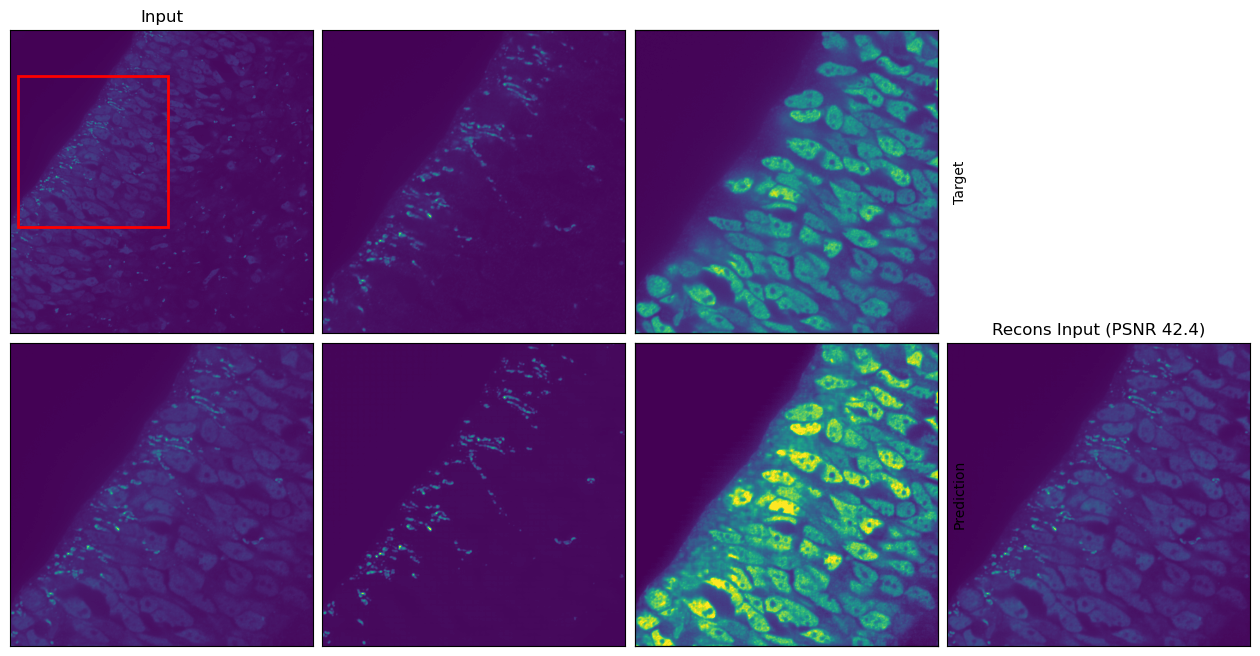

In [61]:
_ = plot_one_sample(normalize_channels(tar_unnorm), pred, inp_unnorm, config, best_t_estimate, img_idx=img_idx, hs=hs, ws=ws)

In [62]:
from disentangle.scripts.evaluate import avg_range_inv_psnr
tar0 = [x[...,0] for x in tar_unnorm]
pred0 = [x[...,0] for x in pred_unnorm]

tar1 = [x[...,1] for x in tar_unnorm]
pred1 = [x[...,1] for x in pred_unnorm]
psnr_ch0 = avg_range_inv_psnr(np.concatenate(tar0,axis=0), np.concatenate(pred0, axis=0))
psnr_ch1 = avg_range_inv_psnr(np.concatenate(tar1,axis=0), np.concatenate(pred1, axis=0))

estimated_input = get_input_normalized(pred,best_t_estimate, channel_pos='last')
mse_input_str = 'MSE-input ' +' '.join([f'{np.mean((gt_tmp - pred_tmp)**2):.2f}' for gt_tmp,pred_tmp in zip(actual_input, estimated_input)])
print(mse_input_str)
print('PSNR', psnr_ch0, psnr_ch1)

MSE-input 0.04
PSNR (38.34, 0.0) (29.64, 0.0)


In [57]:
avg_range_inv_psnr(np.concatenate(tar0[:1],axis=0), np.concatenate(pred0[:1], axis=0)),avg_range_inv_psnr(np.concatenate(tar1[:1],axis=0), np.concatenate(pred1[:1], axis=0))

((41.5, 0.0), (30.57, 0.0))

In [58]:
print(f'F1:{best_factors[0]:.2f} Off1:{best_offsets[0]:.2f} F2:{best_factors[1]:.2f} Off2:{best_offsets[1]:.2f}\t\t PSNR: {psnr_ch0[0]:.2f} {psnr_ch1[0]:.2f} {mse_input_str}')

F1:1.02 Off1:-0.01 F2:1.00 Off2:0.00		 PSNR: 41.50 30.57 MSE-input 0.10


In [59]:
print(f'Target 2 Min:{tar1[0].min():.1f}, Max:{tar1[0].max():.1f}, Mean:{tar1[0].mean():.1f}, Std:{tar1[0].std():.1f}')
print(f'Pred 2 Min:{pred1[0].min():.1f}, Max:{pred1[0].max():.1f}, Mean:{pred1[0].mean():.1f}, Std:{pred1[0].std():.1f}')
print(f'Target 1 Min:{tar0[0].min():.1f}, Max:{tar0[0].max():.1f}, Mean:{tar0[0].mean():.1f}, Std:{tar0[0].std():.1f}')
print(f'Pred 1 Min:{pred0[0].min():.1f}, Max:{pred0[0].max():.1f}, Mean:{pred0[0].mean():.1f}, Std:{pred0[0].std():.1f}')

Target 2 Min:86.0, Max:2078.0, Mean:406.8, Std:313.9
Pred 2 Min:95.8, Max:2125.1, Mean:407.4, Std:320.2
Target 1 Min:109.0, Max:6210.0, Mean:266.2, Std:161.6
Pred 1 Min:125.0, Max:4748.4, Mean:250.8, Std:144.5


In [60]:
factor1

Parameter containing:
tensor(1.0730, device='cuda:0', requires_grad=True)

In [61]:
# reload()
# batch_size = 128
print(max_step_count_step2)
# best_factors[0], best_offsets[0]
if optimaization_mode == 'norm_and_network':
    scalar_param_dict = {'factor1':factor1, 'offset1':offset1, 'factor2':factor2, 'offset2':offset2, 'mixing_ratio':mixing_ratio}
    finetuning_params = [factor1, offset1] + list(model.parameters())
else:
    finetuning_params = model.parameters()
    scalar_param_dict = {'factor1':torch.Tensor([best_factors[0]]).cuda(), 
                                                    'offset1':torch.Tensor([best_offsets[0]]).cuda(), 
                                                    'factor2':torch.Tensor([best_factors[1]]).cuda(), 
                                                    'offset2':torch.Tensor([best_offsets[1]]).cuda(), 
                                                    'mixing_ratio':mixing_ratio}

finetuning_output_dict = finetune_two_forward_passes(model, val_dset, transform_all, max_step_count=max_step_count_step2, 
                                                    batch_size=batch_size, skip_pixels=skip_pixels,
                                                    scalar_params_dict=scalar_param_dict,
                                                    optimization_params_dict={'lr':lr_step2, 
                                                                            #   'parameters': model.first_bottom_up.parameters()
                                                                            'parameters': finetuning_params
                                                                            },
                                                    lookback=lookback,
                                                                k_augmentations=k_augmentations,
                                                                stats_enforcing_loss_fn=lambda x : stats_loss_func(x),
                                                                sample_mixing_ratio=enable_mixing_aug,)

12500
Finetuning with 4 augmentations, batch size 16, max step count 12500, sample mixing ratio True


11it [00:06,  1.77it/s]

Loss Inp Rolling(10): 0.13


65it [00:36,  1.76it/s]

Loss Inp Rolling(10): 0.13


67it [00:37,  1.77it/s]

Loss Inp Rolling(10): 0.12


68it [00:37,  1.74it/s]

Loss Inp Rolling(10): 0.12


69it [00:38,  1.73it/s]

Loss Inp Rolling(10): 0.12


73it [00:40,  1.76it/s]

Loss Inp Rolling(10): 0.11


76it [00:42,  1.75it/s]

Loss Inp Rolling(10): 0.11


77it [00:42,  1.74it/s]

Loss Inp Rolling(10): 0.10


79it [00:44,  1.76it/s]

Loss Inp Rolling(10): 0.10


80it [00:44,  1.75it/s]

Loss Inp Rolling(10): 0.10


81it [00:45,  1.73it/s]

Loss Inp Rolling(10): 0.09


82it [00:45,  1.73it/s]

Loss Inp Rolling(10): 0.09


85it [00:47,  1.76it/s]

Loss Inp Rolling(10): 0.08


88it [00:49,  1.77it/s]

Loss Inp Rolling(10): 0.08


90it [00:50,  1.77it/s]

Loss Inp Rolling(10): 0.07


91it [00:50,  1.76it/s]

Loss Inp Rolling(10): 0.07


93it [00:51,  1.77it/s]

Loss Inp Rolling(10): 0.06


94it [00:52,  1.76it/s]

Loss Inp Rolling(10): 0.06


99it [00:55,  1.78it/s]

Loss Inp Rolling(10): 0.06


100it [00:55,  1.76it/s]

Loss Inp Rolling(10): 0.06


101it [00:56,  1.75it/s]

Loss Inp Rolling(10): 0.06


102it [00:56,  1.74it/s]

Loss Inp Rolling(10): 0.06


103it [00:57,  1.74it/s]

Loss Inp Rolling(10): 0.05


104it [00:58,  1.73it/s]

Loss Inp Rolling(10): 0.05


105it [00:58,  1.73it/s]

Loss Inp Rolling(10): 0.04


106it [00:59,  1.71it/s]

Loss Inp Rolling(10): 0.04


107it [00:59,  1.69it/s]

Loss Inp Rolling(10): 0.04


108it [01:00,  1.69it/s]

Loss Inp Rolling(10): 0.04


121it [01:07,  1.74it/s]

Loss Inp Rolling(10): 0.04


122it [01:08,  1.71it/s]

Loss Inp Rolling(10): 0.04


123it [01:08,  1.69it/s]

Loss Inp Rolling(10): 0.04


124it [01:09,  1.63it/s]

Loss Inp Rolling(10): 0.03


126it [01:10,  1.69it/s]

Loss Inp Rolling(10): 0.03


127it [01:11,  1.69it/s]

Loss Inp Rolling(10): 0.03


128it [01:12,  1.59it/s]

Loss Inp Rolling(10): 0.03


130it [01:13,  1.67it/s]

Loss Inp Rolling(10): 0.03


132it [01:14,  1.72it/s]

Loss Inp Rolling(10): 0.03


135it [01:15,  1.75it/s]

Loss Inp Rolling(10): 0.03


232it [02:09,  1.75it/s]

Loss Inp Rolling(10): 0.03


234it [02:10,  1.75it/s]

Loss Inp Rolling(10): 0.03


275it [02:33,  1.77it/s]

Loss Inp Rolling(10): 0.03


277it [02:34,  1.77it/s]

Loss Inp Rolling(10): 0.03


312it [02:53,  1.78it/s]

Loss Inp Rolling(10): 0.02


607it [05:36,  1.74it/s]

Loss Inp Rolling(10): 0.02


625it [05:46,  1.80it/s]
71it [00:39,  1.76it/s]

Loss Inp Rolling(10): 0.02


72it [00:39,  1.58it/s]

Loss Inp Rolling(10): 0.02


156it [01:26,  1.80it/s]

Loading best model with loss 0.02


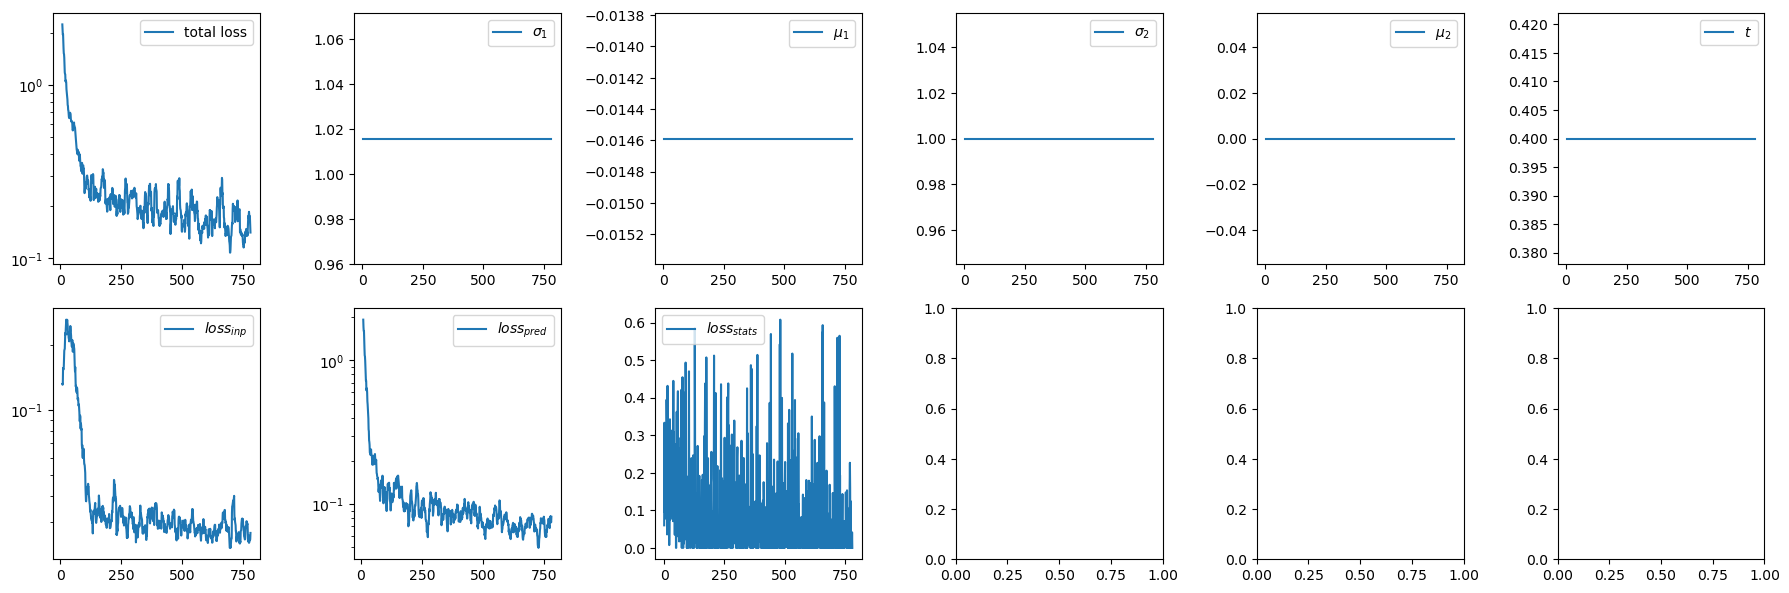

In [62]:
from disentangle.analysis.ssl_plots import plot_finetuning_loss
plot_finetuning_loss(finetuning_output_dict, loss_rolling=10)


In [74]:
pred_tiled, rec_loss, logvar_tiled, patch_psnr_tuple, pred_std_tiled = get_dset_predictions(model, scaled_val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=mmse_count,
                                                model_type = config.model.model_type,
                                              )
tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp))

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:14<00:00, 11.18it/s]

Patch wise PSNR, as computed during training [40.5  21.85] 31.175


In [75]:
pred = stitch_predictions(pred_tiled,val_dset)
pred_unnorm = get_unnorm_pred(pred)

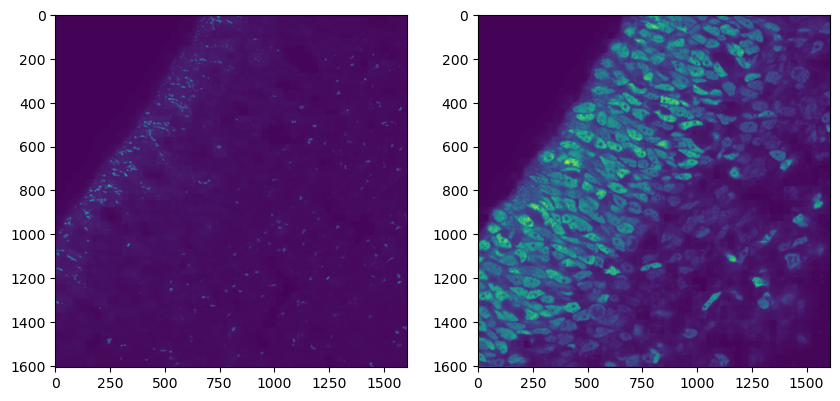

In [76]:
_,ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0].imshow(pred[0][0,...,0])
ax[1].imshow(pred[0][0,...,1])

0 623 427


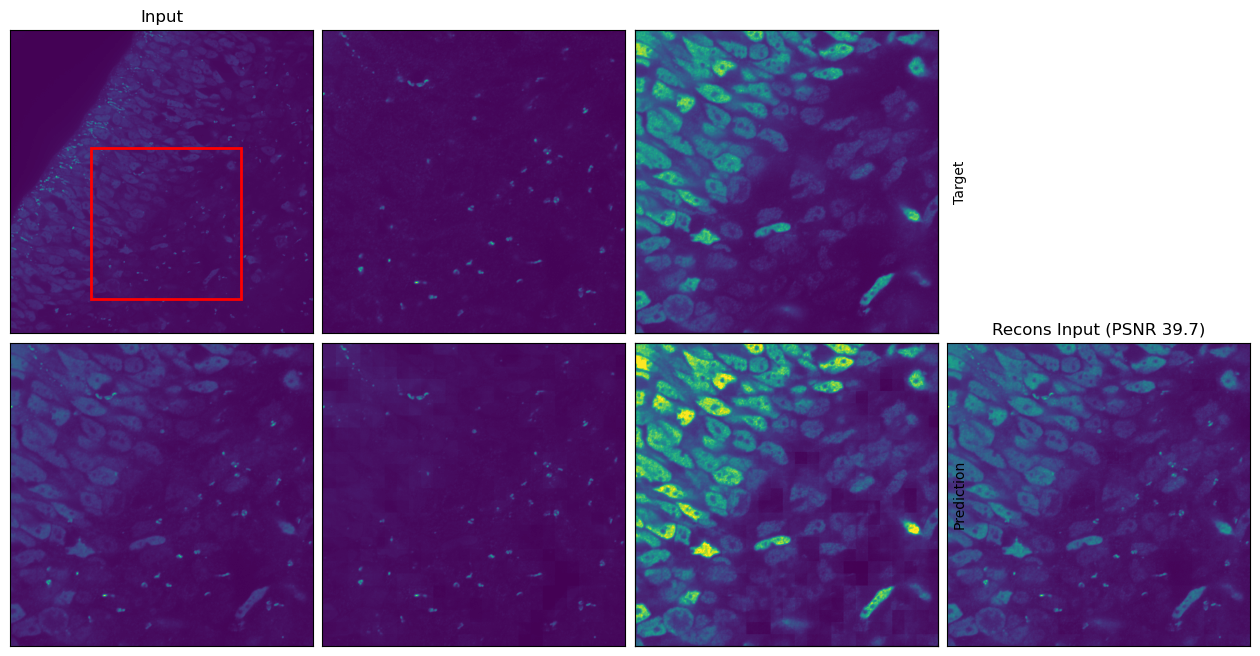

In [77]:
_ = plot_one_sample(normalize_channels(tar_unnorm), pred, inp_unnorm, config, best_t_estimate, img_idx=img_idx, hs=hs, ws=ws)

In [78]:
from disentangle.scripts.evaluate import avg_range_inv_psnr
tar0 = [x[...,0] for x in tar_unnorm]
pred0 = [x[...,0] for x in pred_unnorm]

tar1 = [x[...,1] for x in tar_unnorm]
pred1 = [x[...,1] for x in pred_unnorm]
psnr_ch0 = avg_range_inv_psnr(np.concatenate(tar0,axis=0), np.concatenate(pred0, axis=0))
psnr_ch1 = avg_range_inv_psnr(np.concatenate(tar1,axis=0), np.concatenate(pred1, axis=0))

estimated_input = get_input_normalized(pred,best_t_estimate, channel_pos='last')
mse_input_str = 'MSE-input ' +' '.join([f'{np.mean((gt_tmp - pred_tmp)**2):.2f}' for gt_tmp,pred_tmp in zip(actual_input, estimated_input)])
print(mse_input_str)
print('PSNR', psnr_ch0, psnr_ch1)

MSE-input 0.10
PSNR (42.09, 0.0) (32.17, 0.0)


In [79]:
print(f'F1:{best_factors[0]:.2f} Off1:{best_offsets[0]:.2f} F2:{best_factors[1]:.2f} Off2:{best_offsets[1]:.2f}\t\t PSNR: {psnr_ch0[0]:.2f} {psnr_ch1[0]:.2f} {mse_input_str}')

F1:1.02 Off1:-0.01 F2:1.00 Off2:0.00		 PSNR: 42.09 32.17 MSE-input 0.10


In [69]:
avg_range_inv_psnr(np.concatenate(tar0[:1],axis=0), np.concatenate(pred0[:1], axis=0)),avg_range_inv_psnr(np.concatenate(tar1[:1],axis=0), np.concatenate(pred1[:1], axis=0))

((41.77, 0.0), (31.43, 0.0))

In [70]:
if save_to_file:
    fpath = os.path.join(outputdir, direc, 'after_step2.ckpt')
    os.makedirs(os.path.dirname(fpath), exist_ok=True)
    # save the model weights.
    torch.save(model.state_dict(), fpath)
    print(f'Saved the model weights to {fpath}')


In [71]:
# test_img_raw = val_dset.dsets[0]._data[0,400:656,256:512,0]
# plt.imshow(test_img_raw)

In [72]:
# from finetunesplit.aug_patch_shuffle import GridShuffle
# import torch
# import matplotlib.pyplot as plt

# trans = GridShuffle(256, 128)
# test_img = torch.Tensor(test_img_raw[None, None]*1.0)
# pred, ddict = trans(test_img)
# trans.set_params(ddict['inverse']['shuffle_order'])
# inv_pred, _ = trans(pred)
# _, ax = plt.subplots(figsize=(15,5),ncols=3)
# ax[0].imshow(test_img[0,0])
# ax[1].imshow(pred[0,0])
# ax[2].imshow(inv_pred[0,0])
# ax[0].set_title('Original')
# ax[1].set_title('Shuffled')
# ax[2].set_title('Inverse')